In [103]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

In [104]:
daily_sales_data = pd.read_csv('train.csv')
store_data = pd.read_csv('store.csv')

# This makes it easier to do timeseries analysis later on
convert_dates = partial(datetime.strptime, '%Y-%m-%d')
daily_sales_data['Date'] = daily_sales_data['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Store Counts:

**85%** of Rossman's Stores are **type A/C** with **1.5%** being **type B.**

**99%** of stores are of **assortment A/C**.

100% of assortment B stores are type B.

In [101]:
print(store_data['StoreType'].value_counts())
print('-' * 10)
print(store_data['Assortment'].value_counts())
print('-' * 10)
combinations = sorted([(a, b) for a in store_data['StoreType'].unique() for b in store_data['Assortment'].unique()])
counts = { (a, b):len( store_data[ store_data.StoreType == a ][ store_data.Assortment == b] ) for (a,b) in combinations}
for j in sorted(counts.keys()):
    print('{}/{}: {}'.format(j[0].upper(), j[1].upper(), counts[j]))
print('Name: Store Type / Assortment')

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64
----------
a    593
c    513
b      9
Name: Assortment, dtype: int64
----------
A/A: 381
A/B: 0
A/C: 221
B/A: 7
B/B: 9
B/C: 1
C/A: 77
C/B: 0
C/C: 71
D/A: 128
D/B: 0
D/C: 220
Name: Store Type / Assortment


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Average sales for **type B** stores are **$4000+ higher than A/C/D**

In [17]:
## Is there a store type that does better on average?
def compile_stores(store_numbers):
    """Group the sales daily_sales_data of a list of stores"""
    # Empty daily_sales_dataframe
    filtered_stores = daily_sales_data[daily_sales_data.Sales == -8384]
    for j in store_numbers:
        matches = daily_sales_data[daily_sales_data.Store == j]
        filtered_stores = filtered_stores.append(matches)
    return filtered_stores

def group_by_store_type(store_type, exclude_no_sales=False, attribute='StoreType'):
    store_numbers = list(store_data[store_data[attribute] == store_type]['Store'])
    if exclude_no_sales:
        store_numbers = store_numbers[store_numbers.Sales > 0]
    matches = compile_stores(store_numbers)
    return matches

def plot_sales_averages(type_groups, labels=('A', 'B', 'C', 'D'), sale_color='r', customer_color='y'):
    """Plot the daily_sales_data"""
    indices = np.arange(len(type_groups))
    sales_means = [x.describe()['Sales']['mean'] for x in type_groups]
    customer_means = [x.describe()['Customers']['mean'] for x in type_groups]
    WIDTH = 0.35
    fig, ax = plt.subplots()
    sales_bars = ax.bar(indices, sales_means, WIDTH, color=sale_color)
    customer_bars = ax.bar(indices + WIDTH, customer_means, WIDTH, color=customer_color)
    plt.xticks(indices, labels)
    plt.legend((sales_bars[0], customer_bars[0]), ('Average Sales', 'Average Shoppers'))
    plt.figure()
    sales_daily_sales_data = [np.array(x['Sales']) for x in type_groups]
    plt.boxplot(sales_daily_sales_data, 0 , 'rs')
    plt.xticks(1 + indices,(labels))
    plt.show()
    

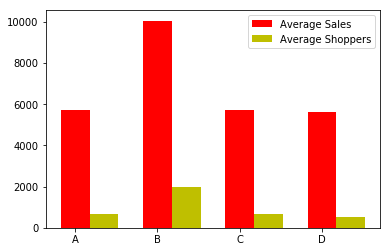

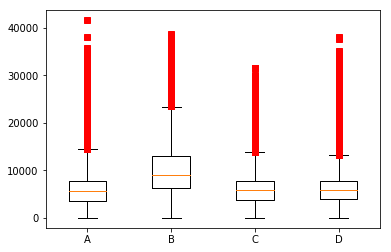

In [106]:
type_a = group_by_store_type('a')
type_b = group_by_store_type('b')
type_c = group_by_store_type('c')
type_d = group_by_store_type('d')

plot_sales_averages((type_a, type_b, type_c, type_d))

In [ ]:
# Is there a store type that is open more than the others
def open_ratio(store_type_daily_sales_data):
    store_type_dates = store_type_daily_sales_data['Date'].unique()
    ratio = 0
    open_count = 0
    total_stores = len(store_type_daily_sales_data)
    for day in store_type_dates:
        open_count = len(store_type_daily_sales_data[store_type_daily_sales_data.Date == day][store_type_daily_sales_data.Open == 1])
        closed_count = len(store_type_daily_sales_data[store_type_daily_sales_data.Date == day][store_type_daily_sales_data.Open == 0])
        ratio += (open_count / (open_count + closed_count))
    return ratio
indices = np.arange(4)
WIDTH = 0.35
open_index = [open_ratio(x) for x in (type_a, type_b, type_c, type_d)]
plt.bar(indices, open_index, WIDTH, color='g')
plt.xticks(indices, ('A', 'B', 'C', 'D'))
plt.show()

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


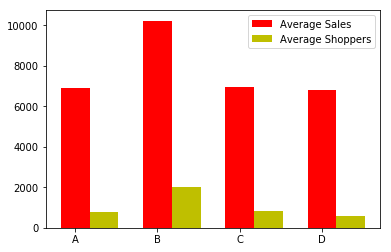

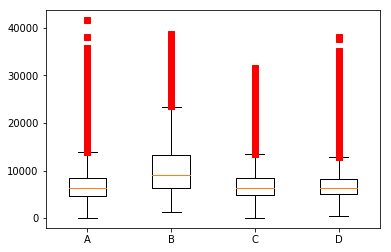

In [38]:
# Excluding Closed Days, is there a type of store that sells more on average?
unclosed_type_a = group_by_store_type('a', True)
unclosed_type_b = group_by_store_type('b', True)
unclosed_type_c = group_by_store_type('c', True)
unclosed_type_d = group_by_store_type('d', True)
plot_sales_averages(unclosed_type_a, unclosed_type_b, unclosed_type_c, unclosed_type_d)

In [5]:
# Does distance from competitor affect sales
def retrieve_quantiles(store_type, attribute):
    return store_data[store_data.StoreType == store_type][attribute].quantile([0.25, 0.50, 0.75])

def retrieve_matches(quantiles):
    q1 = store_data[store_data.CompetitionDistance <= quantiles[0.25]]
    q2 = store_data[store_data.CompetitionDistance > quantiles[0.25]]
    q2 = q2[q2.CompetitionDistance <= quantiles[0.50]]
    q3 = store_data[store_data.CompetitionDistance > quantiles[0.50]]
    q3 = q3[q3.CompetitionDistance <= quantiles[0.75]]
    q4 = store_data[store_data.CompetitionDistance > quantiles[0.75]]
    
    return q1['Store'], q2['Store'], q3['Store'], q4['Store']

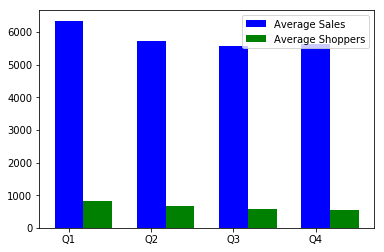

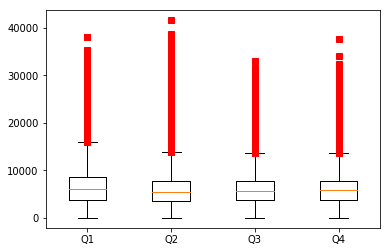

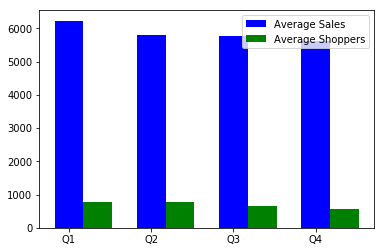

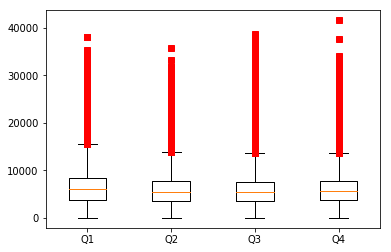

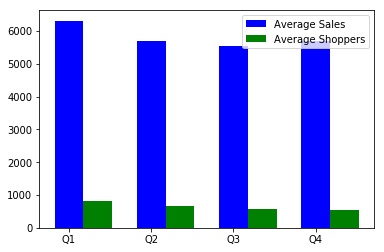

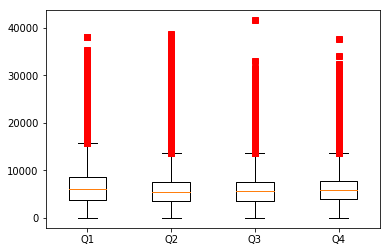

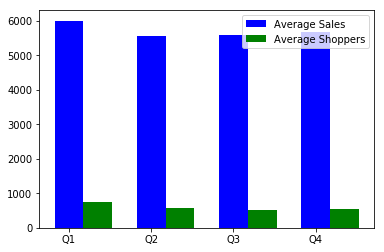

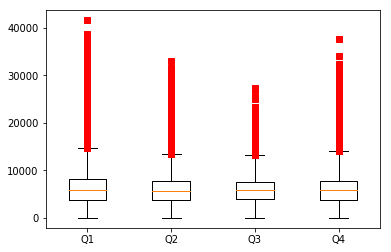

In [7]:
for store_type in ('a', 'b', 'c', 'd'):
    quantiles = retrieve_quantiles(store_type, 'CompetitionDistance')
    q1, q2, q3, q4 = retrieve_matches(quantiles)

    q1 = compile_stores(q1)
    q2 = compile_stores(q2)
    q3 = compile_stores(q3)
    q4 = compile_stores(q4)

    plot_sales_averages((q1, q2, q3, q4), ('Q1', 'Q2', 'Q3', 'Q4'), 'b', 'g')

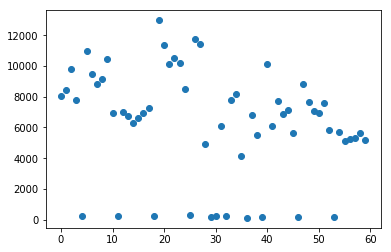

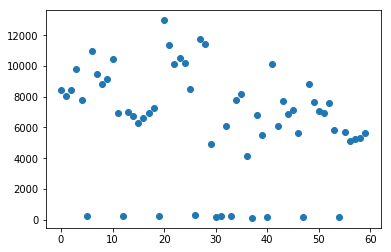

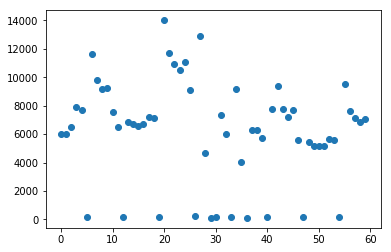

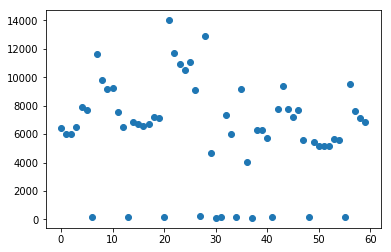

In [8]:
# How do average sales differ before and after state holidays
x = daily_sales_data[daily_sales_data.StateHoliday == 'c']
state_holidays = x['Date'].unique()
n = range(-30, 30)
n_averages = {}
for holi in state_holidays:
    averages = []
    holi = pd.to_datetime(holi)
    before_after_dates = [holi + timedelta(i) for i in n]
    for date in before_after_dates:
        avg = daily_sales_data[daily_sales_data.Date == date].describe()['Sales']['mean']
        averages.append(avg)
    n_averages[holi] = averages
for i in n_averages.keys():
    plt.scatter(range(60), n_averages[i])
    plt.show()

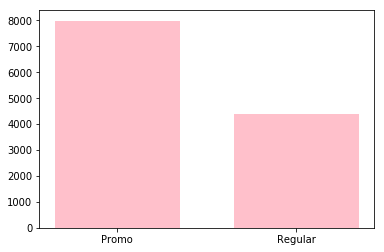

In [11]:
# Do promo days sell more than regular days?
promo_days = daily_sales_data[daily_sales_data.Promo == 1]
promo_avg =  promo_days.describe()['Sales']['mean']
no_promo_days = daily_sales_data[daily_sales_data.Promo == 0]
reg_day_avg = no_promo_days.describe()['Sales']['mean']
plt.bar((0, 0.5), (promo_avg, reg_day_avg), width=0.35, color='pink')
plt.xticks((0, 0.5), ('Promo', 'Regular'))
plt.show()

In [15]:
# Do sales plummet the day after a sale?
promo_dates = promo_days['Date'].unique()
promo_dates = [pd.to_datetime(d) for d in promo_dates]
day_after_promo = [d + timedelta(1) for d in promo_dates]
final_promo_dates = []

for d in promo_dates:
    d = pd.to_datetime(d)
    if d + timedelta(1) not in promo_dates:
        final_promo_dates.append(d)
day_after_promo = [d + timedelta(1) for d in final_promo_dates]
filtered_stores = daily_sales_data[daily_sales_data.Sales == -8843]

for date in day_after_promo:
    filtered_stores = filtered_stores.append(daily_sales_data[daily_sales_data.Date == date])

# Empty daily_sales_dataframe
filtered_stores = daily_sales_data[daily_sales_data.Sales == -8843]

for date in day_after_promo:
    filtered_stores = filtered_stores.append(daily_sales_data[daily_sales_data.Date == date])

day_after_avg = filtered_stores.describe()['Sales']['mean']

filtered_stores2 = daily_sales_data[daily_sales_data.Sales == -8843]
for date in day_after_promo:
    x = daily_sales_data[daily_sales_data.Date != date][daily_sales_data.Promo == 0]
    filtered_stores2 = filtered_stores.append(x)

reg_day_avg2 = filtered_stores2.describe()['Sales']['mean']

print(day_after_avg, reg_day_avg2)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


5935.77350422 4570.52057904


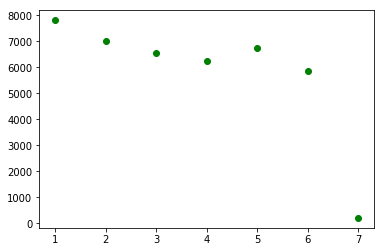

,DayOfWeek,Mean
DayOfWeek,1.000000,-0.761059
Mean,-0.761059,1.000000


In [16]:
# Is there a correlation between sales and day of the week
individual_days = {day: daily_sales_data[daily_sales_data['DayOfWeek'] == day]for day in range(1,8)}
day_of_week_avgs = [individual_days[i].describe()['Sales']['mean'] for i in individual_days.keys()]
plt.scatter(range(1, 8), day_of_week_avgs, color='green')
plt.show()

daily_avgs = pd.daily_sales_dataFrame()
daily_avgs['DayOfWeek'] = range(1, 8)
daily_avgs['Mean'] = day_of_week_avgs

daily_avgs.corr()

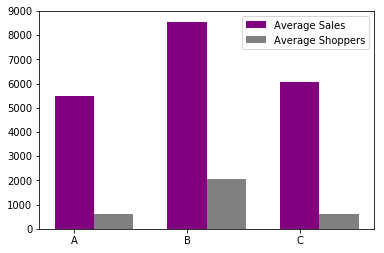

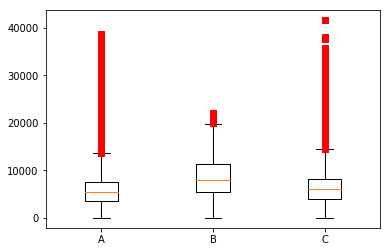

In [25]:
# Is there an assortment type that outperforms in sales? 
assortment_a = group_by_store_type('a', attribute='Assortment')
assortment_b = group_by_store_type('b', attribute='Assortment')
assortment_c = group_by_store_type('c', attribute='Assortment')

plot_sales_averages((assortment_a, assortment_b, assortment_c), labels=('A', 'B', 'C'),
                    sale_color='purple', customer_color='grey')

In [59]:
train.head()
train_labels = train['Sales']
train_daily_sales_data = train.drop(['Store', 'Date', 'Customers', 'Sales'], axis=1)
state_holiday_encoder = LabelEncoder()
train_daily_sales_data['StateHoliday'] = train_daily_sales_data['StateHoliday'].replace(['0', 0], 'z')
train_daily_sales_data['StateHoliday'] = state_holiday_encoder.fit_transform(train_daily_sales_data['StateHoliday'])

valid_labels = valid['Sales']
valid_daily_sales_data = valid.drop(['Store', 'Date', 'Customers', 'Sales'], axis=1)
valid_daily_sales_data['StateHoliday'] = valid_daily_sales_data['StateHoliday'].replace(['0', 0], 'z')
valid_daily_sales_data['StateHoliday'] = state_holiday_encoder.transform(valid_daily_sales_data['StateHoliday'])

